In [67]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [11]:
consumption_values = pd.read_excel('/Users/changsu/Documents/LESIA/Sammanställning_mätvärden_2023_LESIA.xlsx',
                           sheet_name = "Konsumtion mätvärden")
consumption_locations = pd.read_excel('/Users/changsu/Documents/LESIA/Sammanställning_mätvärden_2023_LESIA.xlsx',
                           sheet_name = "Konsumtion anläggningar")

production_values = pd.read_excel('/Users/changsu/Documents/LESIA/Sammanställning_mätvärden_2023_LESIA.xlsx',
                           sheet_name = "Produktion mätvärden")
production_locations = pd.read_excel('/Users/changsu/Documents/LESIA/Sammanställning_mätvärden_2023_LESIA.xlsx',
                           sheet_name = "Produktion anläggningar")

consumption_values.head()

,Anläggnig,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,2023-01-01 00-01,1.977,3.04,9.0,10.91,3.733,9.96,0.0,2.428,1.076,...,22.0,1.0,5.45,124.19,7.514,0.823,3.81,112.84,29.52,14.27
1,2023-01-01 01-02,2.022,3.06,9.0,10.91,3.837,10.45,0.0,2.496,1.101,...,24.0,0.0,5.60,126.73,7.707,1.237,3.83,123.10,41.02,14.00
2,2023-01-01 02-03,2.021,3.07,9.0,10.99,3.834,10.97,0.0,2.494,1.100,...,29.0,0.0,4.88,123.10,7.694,0.909,3.86,124.90,34.76,13.97
3,2023-01-01 03-04,2.035,3.06,9.0,11.15,3.871,8.88,0.0,2.518,1.108,...,24.0,1.0,5.25,127.13,7.759,1.071,3.84,128.87,35.83,13.54
4,2023-01-01 04-05,2.009,3.22,9.0,10.80,3.811,9.13,0.0,2.479,1.095,...,24.0,0.0,5.17,126.74,7.697,1.091,3.83,130.12,34.83,13.83


In [12]:
consumption_values.shape

(8760, 293)

In [13]:
# Noticed that there are 293 columns but the column number ranges from 1 to 296.
# Check which number is missing in the columns.

for i in range(297):
    if i not in consumption_values.columns:
        print(i)

0
24
91
165
232


# Dataset description  

The electricity dataset provided by Boråselnät contains 4 tabs.
* Tab 1 named "Konsumtion mätvärden" is a time series dataset of 292 measurement points (measured locations). The installation index ranges from 1 to 296. The 4 missing columns are 24, 91, 165 and 232. The electricity consumption values are measured at each measurement point, for an entire year of 8760 hours
_Here, anläggning (facility) is the location where the electricity consumption is measured. In some cases, several measurement sites are in the same building, so the electricity consumption values have to be summed up to obtain the consumption of one building, as this is per measurement site and not per building._
* Tab 2 named "Konsumtion anläggningar" provides information of each electricity consumption measurement points, which are: name of the company, address, geographical coordinates and measurement index.
* Tab 3 named "Produktion mätvärden" are values of electricity generation from PV panels installed on some of the buildings.
* Tab 4 named "Produktion anläggningar" provides addresses and installed capacity of the buildings that have PV installed.

# Data analysis plan  

The data analysis plan includes the following directions:
1. **Time Series Analysis:** Explore hourly, daily, weekly, and seasonal patterns and trends in electricity consumption. This can help identify peak usage times and potential stress on the power grid. The time series analysis can be carried out at both whole area level or individual building level.
2. **Cluster Analysis:** Group buildings by similar energy usage patterns using clustering techniques (e.g., K-means, hierarchical clustering). This can reveal buildings with unusually high or low efficiency, and identify best practices or areas for improvement.
3. **Geospatial Analysis:** Use the geo-coordinates to map energy consumption and identify geographical factors affecting energy usage. This can help in understanding how location, climate, and urban density influence electricity demand, which are location-based insights. We could also combine the geographic and consumption data with demographic information to see if certain demographic factors correlate with energy usage patterns.
4. **Predictive Modeling:** Develop machine learning models to predict future energy consumption based on historical data. This can be useful for grid management and in planning energy production and distribution. We could also perform anomaly detection by implementing models to detect unusual patterns of electricity usage that might indicate equipment malfunctions, inefficiencies, or other issues requiring attention.


# Time Series Analysis

The daily, weekly, and seasonal electricity consumption patterns and trends analysis is carried out at both **global level** (for the entire Viared area) and **local level** (for each individual measuring point)

In [14]:
# Show the consumpiton data
consumption_values.head()

,Anläggnig,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,2023-01-01 00-01,1.977,3.04,9.0,10.91,3.733,9.96,0.0,2.428,1.076,...,22.0,1.0,5.45,124.19,7.514,0.823,3.81,112.84,29.52,14.27
1,2023-01-01 01-02,2.022,3.06,9.0,10.91,3.837,10.45,0.0,2.496,1.101,...,24.0,0.0,5.60,126.73,7.707,1.237,3.83,123.10,41.02,14.00
2,2023-01-01 02-03,2.021,3.07,9.0,10.99,3.834,10.97,0.0,2.494,1.100,...,29.0,0.0,4.88,123.10,7.694,0.909,3.86,124.90,34.76,13.97
3,2023-01-01 03-04,2.035,3.06,9.0,11.15,3.871,8.88,0.0,2.518,1.108,...,24.0,1.0,5.25,127.13,7.759,1.071,3.84,128.87,35.83,13.54
4,2023-01-01 04-05,2.009,3.22,9.0,10.80,3.811,9.13,0.0,2.479,1.095,...,24.0,0.0,5.17,126.74,7.697,1.091,3.83,130.12,34.83,13.83


In [15]:
# Describe the basic statistics of the consumption data
consumption_values.describe()

# Noticed that some min values are negative, which could mean there were PV generations.

,1,2,3,4,5,6,7,8,9,10,...,287,288,289,290,291,292,293,294,295,296
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,0.895400,5.657194,17.846911,57.755633,1.704081,11.847721,1.248126,1.133976,0.516909,25.516913,...,86.869937,3.590427,11.148853,115.588682,3.328322,1.008893,5.680132,143.854650,71.587337,28.849208
std,0.955577,5.455673,11.615087,23.084195,1.809294,9.093417,2.369722,1.201913,0.548944,19.297916,...,90.162379,16.594994,5.433579,84.162665,3.539193,0.381674,4.394681,65.468109,42.240824,17.642940
min,0.003000,0.890000,4.208000,9.994000,-0.113000,0.000000,-0.293000,0.003000,0.003000,6.550000,...,0.000000,0.000000,2.170000,-0.810000,-0.009000,0.094000,2.960000,33.090000,19.140000,10.820000
25%,0.004000,2.580000,9.860500,42.067500,0.004000,7.010000,0.000000,0.004000,0.004000,11.090000,...,21.000000,0.169000,6.960000,46.860000,0.004000,0.745750,3.707500,90.217500,37.830000,15.200000
50%,0.004000,3.230000,12.563500,56.864500,0.004000,9.410000,0.000000,0.004000,0.004000,13.060000,...,31.250000,0.282000,10.110000,99.875000,0.004000,1.022000,3.950000,135.055000,52.480000,16.990000
75%,1.993000,7.622500,24.038250,73.920500,3.734000,12.990000,1.262250,2.482000,1.087000,48.760000,...,186.000000,1.000000,13.910000,183.242500,7.343000,1.261000,5.400000,183.910000,108.752500,48.140000
max,2.228000,38.630000,61.079000,126.053000,3.935000,50.240000,11.790000,2.590000,1.331000,76.410000,...,288.000000,190.601000,31.410000,367.640000,7.903000,6.018000,36.590000,381.600000,255.350000,92.200000


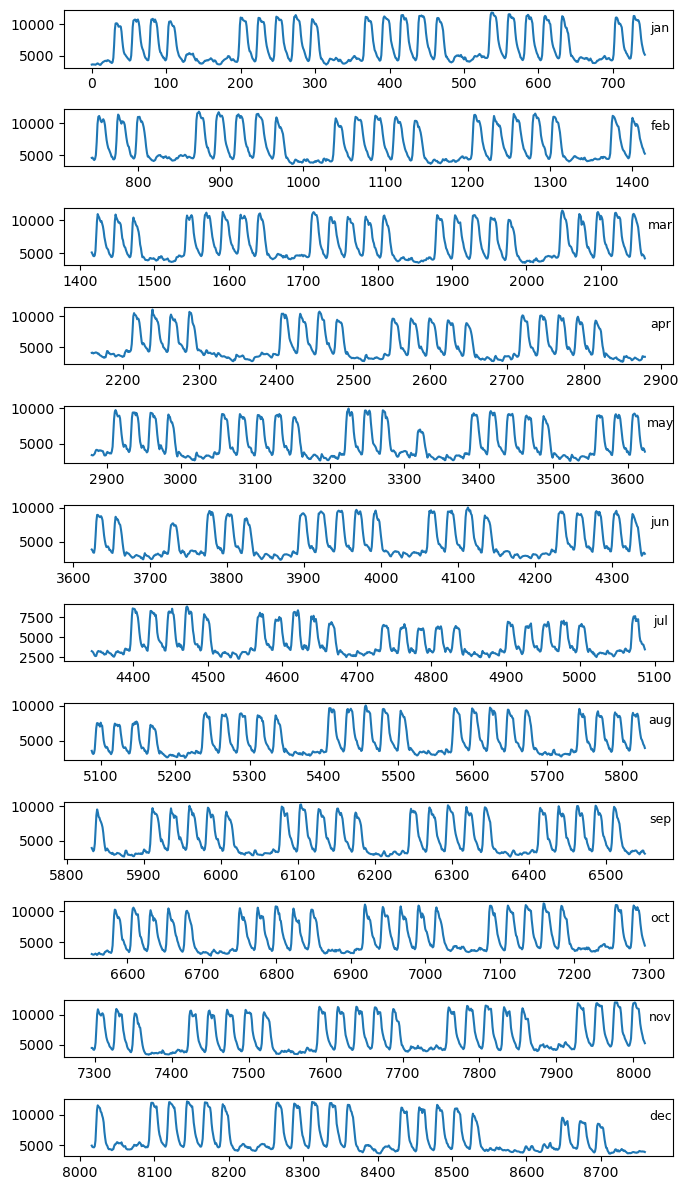

In [16]:
# Global analysis:
# Sum up the electricity consumption for the entire region and analyze
# the global trend for the entire Viared region.

# Hours for each month in a non-leap year (feb has 28 days)
year = {'jan': [i for i in range(744)],
       'feb': [i for i in range(744, 1416)],
        'mar': [i for i in range(1416, 2160)],
        'apr': [i for i in range(2160, 2880)],
        'may': [i for i in range(2880, 3624)],
        'jun': [i for i in range(3624, 4344)],
        'jul': [i for i in range(4344, 5088)],
        'aug': [i for i in range(5088, 5832)],
        'sep': [i for i in range(5832, 6552)],
        'oct': [i for i in range(6552, 7296)],
        'nov': [i for i in range(7296, 8016)],
        'dec': [i for i in range(8016, 8760)]
       }

# Sum up the electricity consumption for the entire Viared region
consumption_sum = consumption_values.iloc[:,1:].sum(axis=1)

# Creat a figute to visualize the result
fig = plt.figure(figsize=(7, 12))
for i, month in enumerate(year.keys()):
    ax = fig.add_subplot(12,1,i+1)
    ax.plot(year[month], consumption_sum.iloc[year[month]])
    ax.set_xlabel(month, fontsize=9)
    ax.xaxis.set_label_coords(0.98, 0.8)

fig.tight_layout()
plt.show()

From the figure above, a clear electricity consumption pattern can be found:

1. The consumption usually goes periodically for each week, which are 5 working days and 2 days weekend. When there happen to be a red day during working days, 4 peaks are shown instead of 5.
2. The variations between working hours and off-working hours are very big (about 5,000 kW). The variations between working days and weekends are also big (about 5,000 kW)
3. Jul is usually a vacation month so the peak (7,500 kW) is lower than other months (10,000 kW)

Insights:
1. Disect into a typical week and explore.
2. Compare with electricity price data and find potentials on peak-shaving and arbitrage. 

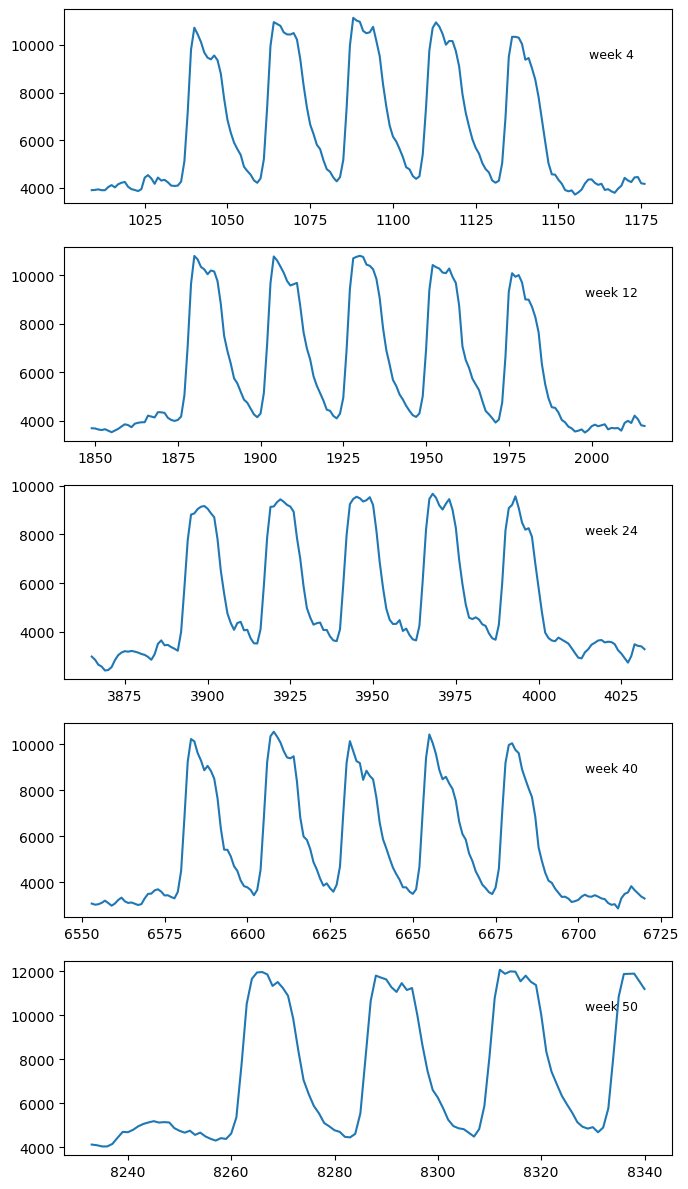

In [17]:
# 1 year has 8760 hours. 
# week 4 ranges from hour 1009 - 1176 (jan)
# week 12: 1849 - 2016 (mar)
# week 24: 3865 - 4032 (jun)
# week 40: 6553 - 6720 (oct)
# week 50: 8233 - 8340 (dec)

weeks_selected = {'week 4': [i for i in range(1009, 1177)],
                  'week 12': [i for i in range(1849, 2017)],
                  'week 24': [i for i in range(3865, 4033)],
                  'week 40': [i for i in range(6553, 6721)],
                  'week 50': [i for i in range(8233, 8341)]
                }

# Visualize the weeks
fig = plt.figure(figsize=(7, 12))
for i, week in enumerate(weeks_selected.keys()):
    ax = fig.add_subplot(5,1,i+1)
    ax.plot(weeks_selected[week], consumption_sum.iloc[weeks_selected[week]])
    ax.set_xlabel(week, fontsize=9)
    ax.xaxis.set_label_coords(0.9, 0.8)

fig.tight_layout()
plt.show()

Insights from the above figure:  
1. Investigate possibility of arbitrage by using energy storage solutions between peaks and valleys
2. Investigate PV potentials and see how it can shave peaks
3. Investigate if different companies can reschedule their working hours to help shave the peaks

All requires electricity price data.

In [10]:
# Obtain the hourly electricity data from SE3 region
# Data source: https://transparency.entsoe.eu/dashboard/show

elprice2023 = pd.read_csv('Day-ahead Prices_202301010000-202401010000.csv')
elprice2023.head()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|SE3
0,01.01.2023 00:00 - 01.01.2023 01:00,2.01,EUR,NaN
1,01.01.2023 01:00 - 01.01.2023 02:00,1.38,EUR,NaN
2,01.01.2023 02:00 - 01.01.2023 03:00,0.09,EUR,NaN
3,01.01.2023 03:00 - 01.01.2023 04:00,0.08,EUR,NaN
4,01.01.2023 04:00 - 01.01.2023 05:00,0.05,EUR,NaN


In [11]:
elprice2023.shape

(8761, 4)

The data has 8761 hours. The most common reason for an Excel sheet with hourly data to have 8761 rows instead of 8760 for a full year is the inclusion of an extra hour due to daylight saving time. 
* **Daylight Saving Time Adjustment**: In many regions, clocks are adjusted forward by one hour in the spring ("spring forward") and adjusted back by one hour in the fall ("fall back"). This adjustment typically occurs at 2:00 AM, meaning in the spring, the hour from 2:00 AM to 3:00 AM effectively disappears, which could result in one less hour. However, Excel sheets often still show a nominal 2:00 AM to 3:00 AM slot. In the fall, the hour from 2:00 AM to 3:00 AM is repeated, resulting in this hour occurring twice. This could explain why your Excel sheet has an extra line, representing the additional hour.
* **How to Identify the Extra Hour**: Check the dates when daylight saving time changes occurred. These are usually on a Sunday and happen in March (spring forward) and November (fall back) in many regions. Look closely at the hour entries for these dates. For the "fall back" date, you should see an hour repeated, typically the 2:00 AM hour.
* Handling the "Spring Forward" Event
For the spring forward event on March 26, 2023, the hour from 2:00 AM to 3:00 AM disappeared. This is expected because the clock skips this hour. Usually, there's no need to make adjustments here since the dataset reflects the actual hours that exist.

* Handling the "Fall Back" Event
For the fall back event on October 29, 2023, where the hour from 2:00 AM to 3:00 AM is duplicated, a few options cab be chosen for dealing with the duplicate entries:
    * Average the Prices: If the goal is to maintain a consistent hourly dataset that reflects a smoothed-out price impact, you can average the prices for the duplicated hour. This means combining the prices of the two entries for the 2:00 AM to 3:00 AM slot and using the average as the price for that hour.
    * Choose One Entry: Depending on your specific analysis needs or the guidelines of your analysis:
    * Use the First Entry: This can be justified if you consider the first 2:00 AM as the continuation of the original time before the backward shift.  
    * Use the Second Entry: This might be preferable if the second entry is considered more reflective of typical conditions for that hour under standard time.  
    * Retain Both Entries with Adjustment: If your analysis can accommodate more detailed data manipulation, you could adjust the timestamps to reflect a 2:00 AM and a 2:00 AM DST or similar notation, keeping both prices but distinguishing them clearly in your analysis.


In [12]:
elprice2023.iloc[2017:2020, :]
# Row 2018 price data is missing due to time adjustment.
# Use np.fillna()

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|SE3
2017,26.03.2023 01:00 - 26.03.2023 02:00,39.23,EUR,NaN
2018,26.03.2023 02:00 - 26.03.2023 03:00,NaN,NaN,NaN
2019,26.03.2023 03:00 - 26.03.2023 04:00,40.12,EUR,NaN


In [13]:
# fill the missing value of row 2018 using the average of row 2017 and 2019

value2017 = elprice2023.iloc[2017, 1]
value2019 = elprice2023.iloc[2019, 1]
value2018 = (value2017 + value2019) / 2

elprice2023.iloc[2018, 1] = value2018
elprice2023.iloc[2017:2020, :]

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|SE3
2017,26.03.2023 01:00 - 26.03.2023 02:00,39.230,EUR,NaN
2018,26.03.2023 02:00 - 26.03.2023 03:00,39.675,NaN,NaN
2019,26.03.2023 03:00 - 26.03.2023 04:00,40.120,EUR,NaN


In [14]:
elprice2023.iloc[7225:7229, :]
# Row 7226 and 7227 have duplicated time 02:00 - 03:00, take away row 7227

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,BZN|SE3
7225,29.10.2023 01:00 - 29.10.2023 02:00,27.19,EUR,NaN
7226,29.10.2023 02:00 - 29.10.2023 03:00,25.34,EUR,NaN
7227,29.10.2023 02:00 - 29.10.2023 03:00,22.35,EUR,NaN
7228,29.10.2023 03:00 - 29.10.2023 04:00,21.15,EUR,NaN


In [15]:
# Row 7226 and 7227 have duplicated time 02:00 - 03:00, take away row 7227
price2023 = elprice2023.drop(index=7227)
price2023.reset_index(drop=True, inplace=True)
price2023.shape

(8760, 4)

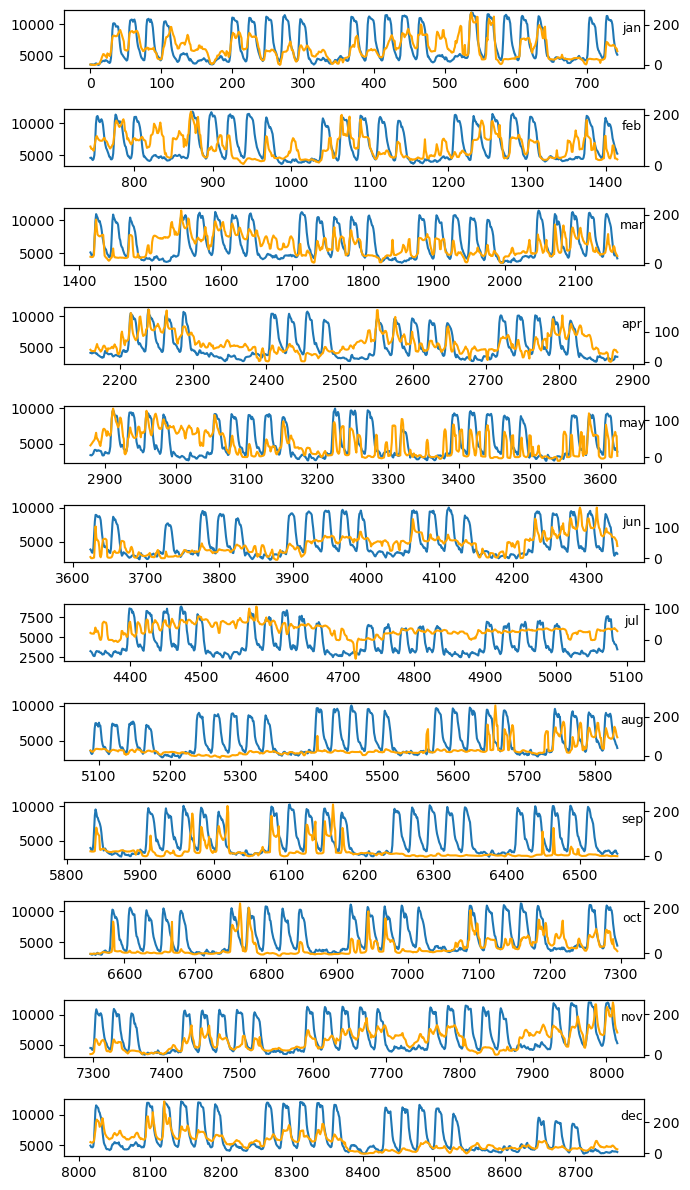

In [24]:
# Now, plot the hourly price of SE3 in year 2023 with electricity consumption of entire Viared area, consumption_sum

# Hours for each month in a non-leap year (feb has 28 days)
year = {'jan': [i for i in range(744)],
       'feb': [i for i in range(744, 1416)],
        'mar': [i for i in range(1416, 2160)],
        'apr': [i for i in range(2160, 2880)],
        'may': [i for i in range(2880, 3624)],
        'jun': [i for i in range(3624, 4344)],
        'jul': [i for i in range(4344, 5088)],
        'aug': [i for i in range(5088, 5832)],
        'sep': [i for i in range(5832, 6552)],
        'oct': [i for i in range(6552, 7296)],
        'nov': [i for i in range(7296, 8016)],
        'dec': [i for i in range(8016, 8760)]
       }

# Sum up the electricity consumption for the entire Viared region
consumption_sum = consumption_values.iloc[:,1:].sum(axis=1)

# Creat a figute to visualize the result
fig = plt.figure(figsize=(7, 12))
for i, month in enumerate(year.keys()):
    ax = fig.add_subplot(12,1,i+1)
    ax.plot(year[month], consumption_sum.iloc[year[month]])
    ax.set_xlabel(month, fontsize=9)
    ax.xaxis.set_label_coords(0.98, 0.8)

    ax_price = ax.twinx()
    ax_price.plot(year[month], price2023.iloc[year[month], 1], 
                  color='orange')

fig.tight_layout()
plt.show()

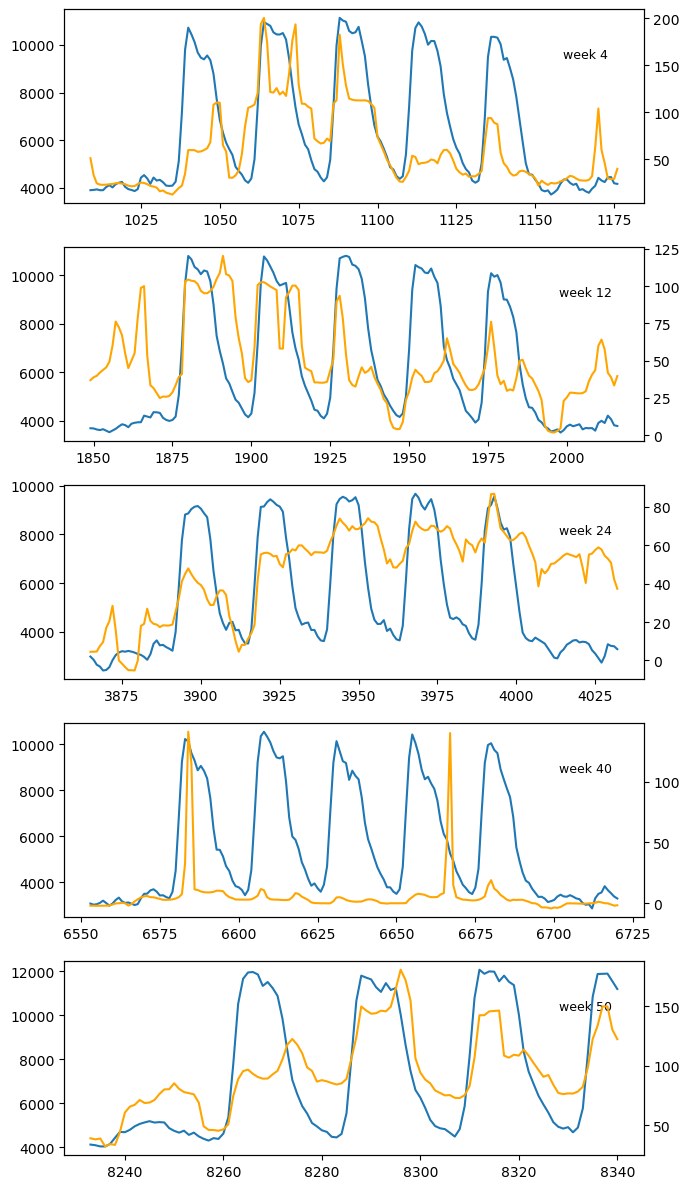

In [25]:
# 1 year has 8760 hours. 
# week 4 ranges from hour 1009 - 1176 (jan)
# week 12: 1849 - 2016 (mar)
# week 24: 3865 - 4032 (jun)
# week 40: 6553 - 6720 (oct)
# week 50: 8233 - 8340 (dec)

weeks_selected = {'week 4': [i for i in range(1009, 1177)],
                  'week 12': [i for i in range(1849, 2017)],
                  'week 24': [i for i in range(3865, 4033)],
                  'week 40': [i for i in range(6553, 6721)],
                  'week 50': [i for i in range(8233, 8341)]
                }

# Visualize the weeks
fig = plt.figure(figsize=(7, 12))
for i, week in enumerate(weeks_selected.keys()):
    ax = fig.add_subplot(5,1,i+1)
    ax.plot(weeks_selected[week], consumption_sum.iloc[weeks_selected[week]])
    ax.set_xlabel(week, fontsize=9)
    ax.xaxis.set_label_coords(0.9, 0.8)

    ax_price = ax.twinx()
    ax_price.plot(weeks_selected[week], price2023.iloc[weeks_selected[week], 1], 
                  color='orange')

fig.tight_layout()
plt.show()

The figure above inplies possibility of Demand Side Managment (DSM) to shave peaks in oreder to obtain arbitrage.  

There are 292 measurement points, except for 31, 32 are duplicated measurement poins, and 79, 80, 81 are duplicated points, they in total represent 289 different electricity subscribers. Randomly select and check the consumption patterns of the subscribers:

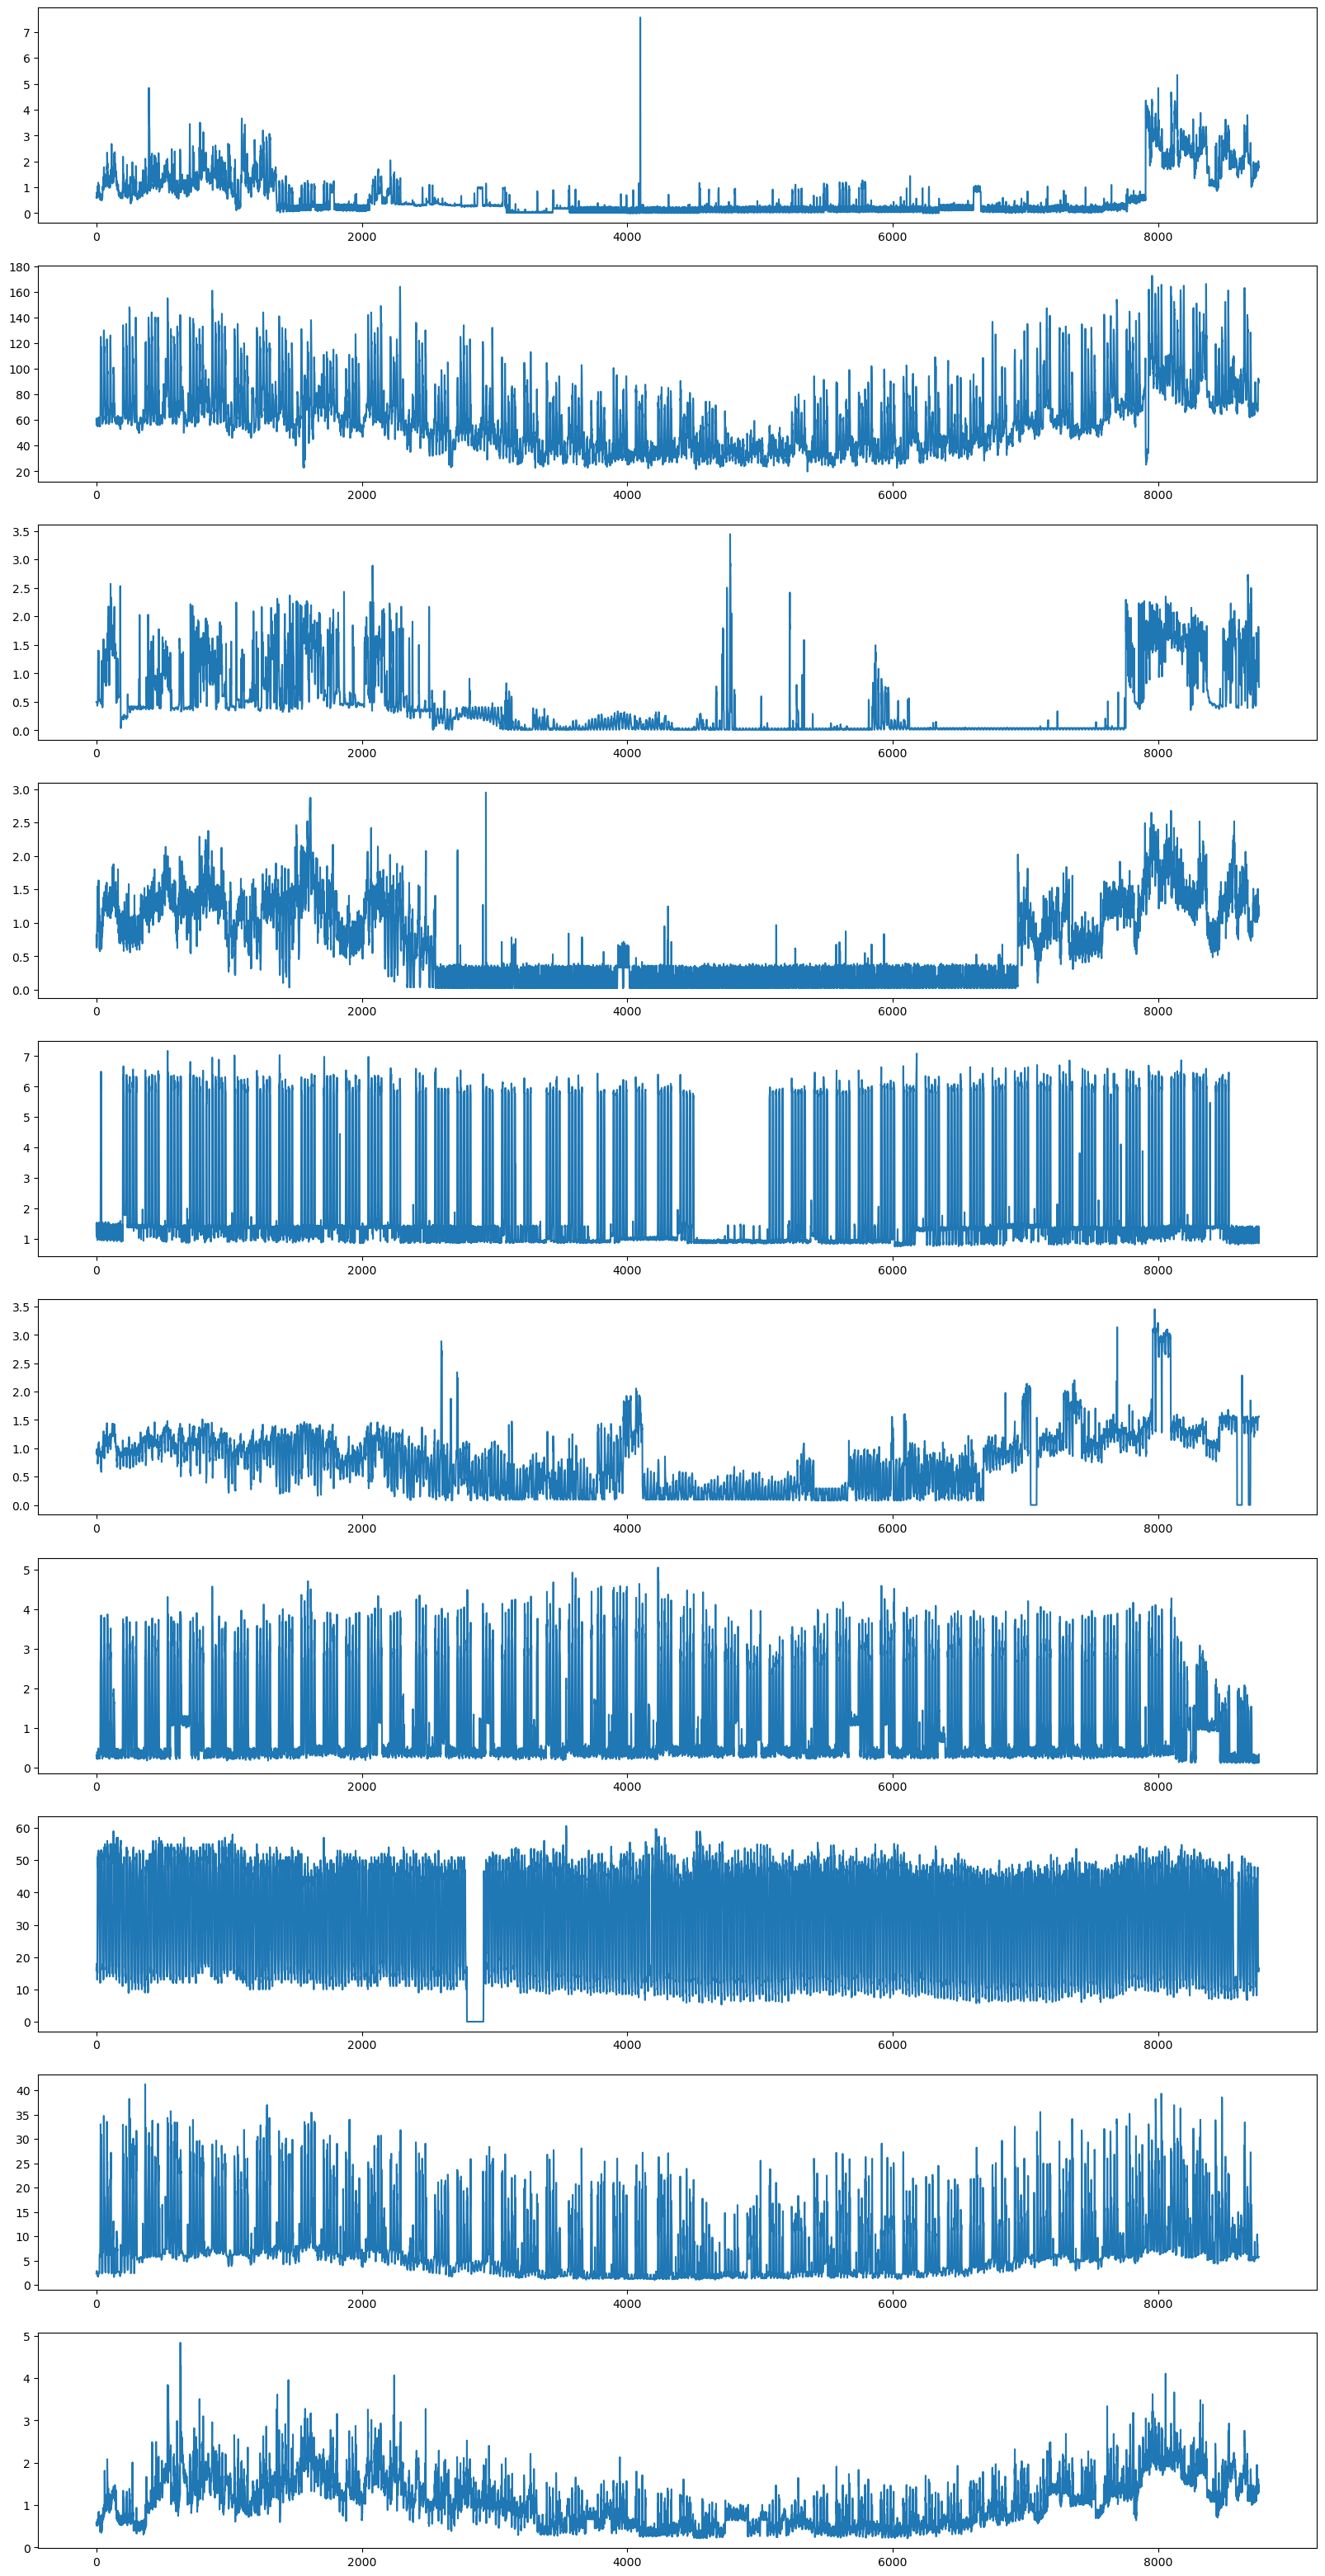

In [80]:
# 
fig = plt.figure(figsize=(20,40))

for i in range(1, 11):
    ax = fig.add_subplot(10,1,i)
    ax.plot(range(8760), consumption_values.iloc[:, 1 + i*25])
    

plt.show()


# Cluster analysis

The electricity consumption pattern above shows heterogenity, which implies possibility of DSM. We could cluster different types of consumption patterns (buildings) and compare them with meta data, in order to group them and investigate possible DSM strategeis.  

Unsupervised learning methods are used to cluster load profiles.

In [70]:
consumptions = consumption_values.drop('Anläggnig', axis=1)
consumptions.head()

,1,2,3,4,5,6,7,8,9,10,...,287,288,289,290,291,292,293,294,295,296
0,1.977,3.04,9.0,10.91,3.733,9.96,0.0,2.428,1.076,13.09,...,22.0,1.0,5.45,124.19,7.514,0.823,3.81,112.84,29.52,14.27
1,2.022,3.06,9.0,10.91,3.837,10.45,0.0,2.496,1.101,13.10,...,24.0,0.0,5.60,126.73,7.707,1.237,3.83,123.10,41.02,14.00
2,2.021,3.07,9.0,10.99,3.834,10.97,0.0,2.494,1.100,13.35,...,29.0,0.0,4.88,123.10,7.694,0.909,3.86,124.90,34.76,13.97
3,2.035,3.06,9.0,11.15,3.871,8.88,0.0,2.518,1.108,13.24,...,24.0,1.0,5.25,127.13,7.759,1.071,3.84,128.87,35.83,13.54
4,2.009,3.22,9.0,10.80,3.811,9.13,0.0,2.479,1.095,13.11,...,24.0,0.0,5.17,126.74,7.697,1.091,3.83,130.12,34.83,13.83


In [71]:
# Check missing values in the dataset

# consumptions.loc[:, consumptions.isnull().any().tolist()]
consumptions.loc[:, consumptions.isna().any().tolist()]
consumptions.fillna(0, inplace=True)
consumptions.loc[:, consumptions.isna().any().tolist()]

""
0
1
2
3
4
...
8755
8756
8757
8758


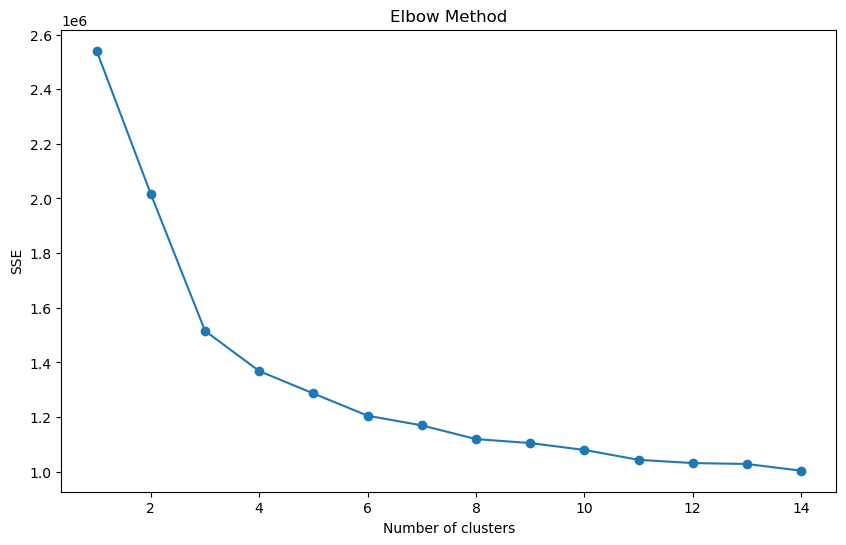

              1          2          3          4         5          6    \
Cluster                                                                   
0        0.011093  11.192324  32.939731  83.047993  0.018578  14.485122   
1        1.443437   3.671671  13.316093  41.423710  3.266528  10.589865   
2        0.181047  14.243301  34.953639  68.574898  0.355263  29.380989   
3        0.931378   2.490408  10.438108  55.267292  1.694736   6.138415   
4        1.657858   3.303580  12.551037  45.967809  2.966020  10.616564   

              7         8         9          10   ...         287        288  \
Cluster                                           ...                          
0        0.418355  0.012739  0.008180  51.270910  ...  203.121392   5.434469   
1        5.599818  2.149585  0.924784  18.529569  ...   40.480494   3.760359   
2        2.575717  0.235583  0.116940  54.305534  ...  232.898235  12.847136   
3        0.347660  1.142805  0.504459  13.220657  ...   30.089423   0.7559

In [66]:
# Transpose DataFrame so that buildings are rows and hours are columns
consumptions = consumptions.T

# Standardize the data
scaler = StandardScaler()
consumptions_scaled = scaler.fit_transform(consumptions)

# Elbow method to find the optimal number of clusters
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(consumptions_scaled)
    sse.append(kmeans.inertia_)

# Plot SSE for each k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Choose a k based on the elbow plot and fit the k-means model
k_opt = 5  # Example: choose 5 based on the elbow plot
kmeans = KMeans(n_clusters=k_opt, random_state=42)
clusters = kmeans.fit_predict(consumptions_scaled)

# Add cluster labels back to the original (transposed) DataFrame
consumptions['Cluster'] = clusters

# Analyze cluster results
print(consumptions.groupby('Cluster').mean())

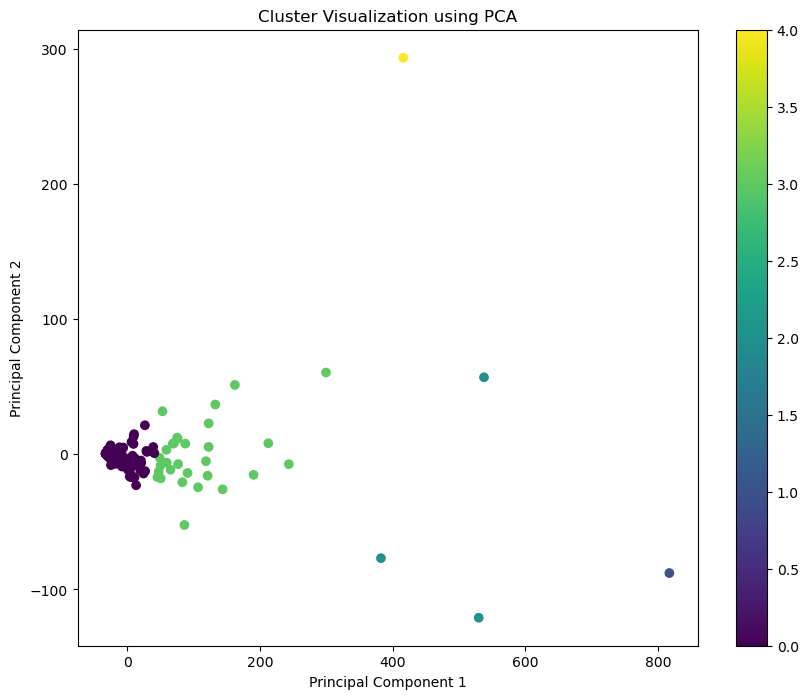

In [73]:
# Transpose
consumptions = consumptions.T

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(consumptions)

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', label=pca_df['Cluster'])
plt.title('Cluster Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()


In [74]:
consumptions

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
1,1.977,2.022,2.021,2.035,2.009,2.121,2.145,2.139,0.980,0.004,...,0.004,0.422,1.510,1.516,1.525,1.529,1.531,1.502,1.492,1.389
2,3.040,3.060,3.070,3.060,3.220,3.010,3.060,2.980,2.610,1.790,...,2.430,3.490,3.480,3.470,3.500,3.480,3.460,3.560,3.430,3.450
3,9.000,9.000,9.000,9.000,9.000,9.000,8.000,9.000,10.000,9.000,...,12.640,14.187,14.247,14.202,14.271,14.357,14.364,14.339,14.192,14.271
4,10.910,10.910,10.990,11.150,10.800,10.970,10.900,10.720,11.030,10.930,...,10.307,10.869,10.626,10.116,10.243,10.218,10.180,10.864,10.829,10.363
5,3.733,3.837,3.834,3.871,3.811,3.699,3.695,3.680,1.688,0.004,...,0.004,1.021,3.698,3.732,3.763,3.776,3.783,3.810,3.783,3.807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,0.823,1.237,0.909,1.071,1.091,0.813,0.833,0.824,1.075,1.046,...,1.618,1.896,1.703,1.397,1.461,1.202,1.305,1.454,1.169,1.369
293,3.810,3.830,3.860,3.840,3.830,3.850,3.830,3.810,3.810,3.830,...,3.310,3.480,3.920,3.880,3.930,3.920,3.900,3.920,4.000,4.030
294,112.840,123.100,124.900,128.870,130.120,120.500,118.770,112.810,117.430,116.320,...,150.340,146.270,146.310,136.350,127.830,126.820,125.440,125.020,121.350,121.500
295,29.520,41.020,34.760,35.830,34.830,39.330,34.660,35.600,41.620,33.340,...,48.090,31.510,59.040,37.490,60.130,33.390,55.210,26.750,47.580,33.640


In [76]:
set(pca_df['Cluster'])

{0, 1, 2, 3, 4}

(array([257.,   0.,   1.,   0.,   0.,   3.,   0.,  30.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

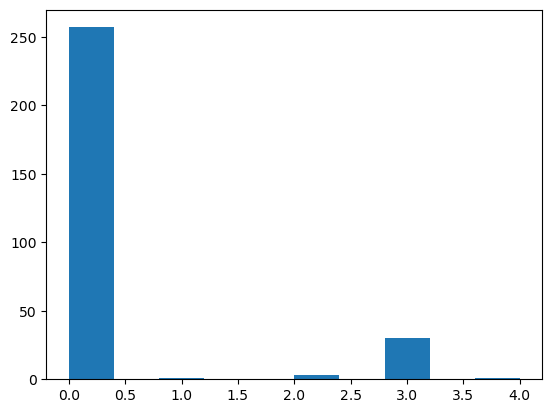

In [78]:
plt.hist(pca_df['Cluster'])

In [4]:
vinst = 50
inköpningspris = 280
försälningspris = 650
kostnad = 20

uppskovsbelopp = (vinst * inköpningspris) / (försälningspris - kostnad)
print('Uppskovsbelopp:', uppskovsbelopp)
tax = (vinst - uppskovsbelopp) * 0.22
print('Tax:', tax)

Uppskovsbelopp: 22.22222222222222
Tax: 6.111111111111112


In [97]:
5490000 - 4240000

1250000

In [101]:
df = consumptions.T
df

,1,2,3,4,5,6,7,8,9,10,...,287,288,289,290,291,292,293,294,295,296
0,1.977,3.04,9.000,10.910,3.733,9.96,0.000,2.428,1.076,13.09,...,22.00,1.000,5.45,124.19,7.514,0.823,3.81,112.84,29.52,14.27
1,2.022,3.06,9.000,10.910,3.837,10.45,0.000,2.496,1.101,13.10,...,24.00,0.000,5.60,126.73,7.707,1.237,3.83,123.10,41.02,14.00
2,2.021,3.07,9.000,10.990,3.834,10.97,0.000,2.494,1.100,13.35,...,29.00,0.000,4.88,123.10,7.694,0.909,3.86,124.90,34.76,13.97
3,2.035,3.06,9.000,11.150,3.871,8.88,0.000,2.518,1.108,13.24,...,24.00,1.000,5.25,127.13,7.759,1.071,3.84,128.87,35.83,13.54
4,2.009,3.22,9.000,10.800,3.811,9.13,0.000,2.479,1.095,13.11,...,24.00,0.000,5.17,126.74,7.697,1.091,3.83,130.12,34.83,13.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1.529,3.48,14.357,10.218,3.776,9.03,6.920,2.502,1.136,13.30,...,23.50,0.267,7.07,47.71,7.308,1.202,3.92,126.82,33.39,16.21
8756,1.531,3.46,14.364,10.180,3.783,9.58,6.469,2.503,1.137,13.13,...,25.35,0.440,8.91,47.34,7.315,1.305,3.90,125.44,55.21,16.82
8757,1.502,3.56,14.339,10.864,3.810,9.28,6.504,2.521,1.142,13.05,...,30.86,0.334,8.90,46.00,7.355,1.454,3.92,125.02,26.75,16.78
8758,1.492,3.43,14.192,10.829,3.783,9.06,6.522,2.503,1.109,12.93,...,38.14,0.441,9.19,45.68,7.240,1.169,4.00,121.35,47.58,16.35


In [105]:
for i in range(1, 3):
    q = df[i].quantile(0.25)
    print(q)

0.00399999999899592
2.58


In [124]:
a = pd.DataFrame({'Numbers': [1, 2, 3, 4, 5, 6]})
a

,Numbers
0,1
1,2
2,3
3,4
4,5
5,6


In [128]:
a.quantile([0.25, 0.5, 0.75], interpolation='higher')

,Numbers
0.25,3
0.50,4
0.75,5


In [118]:
b = pd.DataFrame({'Numbers': [1, 2, 3, 4, 5, 6, 7, 8]})
b

,Numbers
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8


In [119]:
b.quantile([0.25, 0.5, 0.75])

,Numbers
0.25,2.75
0.50,4.50
0.75,6.25


In [129]:
df.quantile()

1        0.0040
2        3.2300
3       12.5635
4       56.8645
5        0.0040
         ...   
292      1.0220
293      3.9500
294    135.0550
295     52.4800
296     16.9900
Name: 0.5, Length: 292, dtype: float64

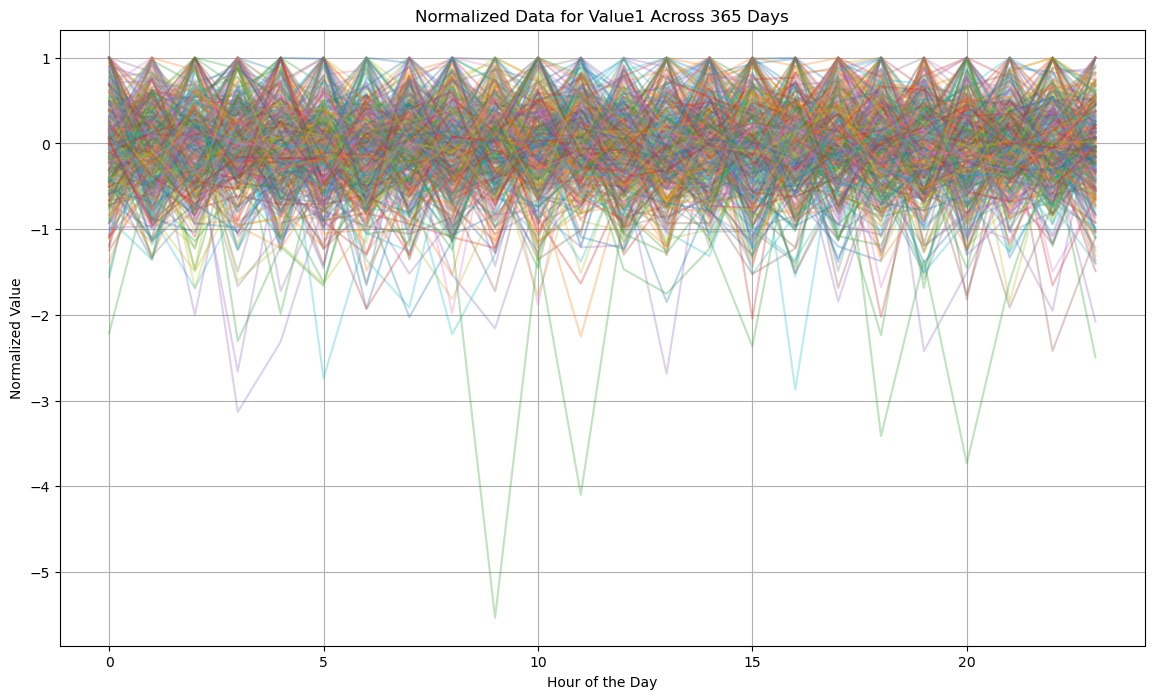

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create sample data
np.random.seed(0)
data = pd.DataFrame({
    'Value1': np.random.randn(8760),
    'Value2': np.random.randn(8760)
})

# Create MultiIndex for days and hours
days = np.repeat(np.arange(1, 366), 24)
hours = np.tile(np.arange(0, 24), 365)
multi_index = pd.MultiIndex.from_arrays([days, hours], names=['Day', 'Hour'])
data.index = multi_index

# Function to normalize data within each day
def normalize_day(df):
    max_values = df.max()
    normalized_df = df / max_values
    return normalized_df

# Apply the normalization function to each day
normalized_data = data.groupby('Day').apply(normalize_day)

# Plot all 365 days in one figure for 'Value1'
plt.figure(figsize=(14, 8))

for day in range(1, 366):
    plt.plot(normalized_data.loc[day].index.get_level_values('Hour'), normalized_data.loc[day, 'Value1'], label=f'Day {day}', alpha=0.3)

plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Value')
plt.title('Normalized Data for Value1 Across 365 Days')
plt.grid(True)
plt.show()


In [131]:
df = pd.DataFrame({
    'A': [10, 12, 14, 16, 18, 100],
    'B': [5, 7, 9, 11, 13, -50]
})
outliers = find_outliers_iqr(df)
df_replaced = replace_outliers_with_sma(df, outliers)
print("Original DataFrame:\n", df)
print("Outliers:\n", outliers)
print("DataFrame after replacing outliers with SMA:\n", df_replaced)

Original DataFrame:
      A   B
0   10   5
1   12   7
2   14   9
3   16  11
4   18  13
5  100 -50
Outliers:
        A      B
0  False  False
1  False  False
2  False  False
3  False  False
4  False  False
5   True   True
DataFrame after replacing outliers with SMA:
     A   B
0  10   5
1  12   7
2  14   9
3  16  11
4  18  13
5  18  13


In [135]:
6 // 2

3

In [6]:
df = pd.DataFrame({'angles': [0, 3, 4], 'degrees': [360, 180, 360]}, index=['circle', 'triangle', 'rectangle'])

# Divide by constant (10)
result = df.div(10)
# Reverse division (rdiv)
reverse_result = df.rdiv(10)

# Subtract a list and Series by axis
subtracted = df.sub([1, 2], axis='columns')
df

,angles,degrees
circle,0,360
triangle,3,180
rectangle,4,360


In [7]:
result

,angles,degrees
circle,0.0,36.0
triangle,0.3,18.0
rectangle,0.4,36.0


In [8]:
reverse_result

,angles,degrees
circle,inf,0.027778
triangle,3.333333,0.055556
rectangle,2.500000,0.027778


In [16]:
price2023.to_csv('./Load_profiles/elprice2023.csv')